# The Linear Perceptron

This notebook will walk you through a simple machine learning algorithm: the linear perceptron (henceforth just "the perceptron," it's cleaner).  This tool is foundational to neural networks which, if you haven't already heard, are [beating us at all our games](https://en.wikipedia.org/wiki/AlphaGo), will soon be [chaffeuring us around](https://arxiv.org/pdf/1604.07316.pdf?iframe=true&width=1040&height=620) and imitating some of our [less desirable](https://www.nytimes.com/2019/12/13/technology/autonomous-weapons-video.html) [characteristics](http://www3.weforum.org/docs/WEF_40065_White_Paper_How_to_Prevent_Discriminatory_Outcomes_in_Machine_Learning.pdf) too.

## Our Fish Classification Problem

Suppose we're working on a fishing boat and we have a license to catch Fish 0 but not Fish 1.  The trouble is both Fish look almost identical in terms of their coloring and shape.  Fish 1 can be distinguished by the fact that they tend to be heavier and shorter than fish 0.  Just by looking at these features, how can we teach a computer to distinguish the two fish?

Lets describe each fish's features by a vector $\vec{x} = \begin{bmatrix} s \\ l \end{bmatrix}$ where $s$ is a fish's mass and $l$ is a fish's length.

### Generating dummy data (may be skipped)
The next code block isn't meant to be understood at this stage; it's just generating fake fish data.  By the end of the course, we'll cover the ideas in this code, including multivariate normal distributions, which are meant to mimic realistic spreads of data in which variables are correlated.

In [47]:
import numpy as np

import matplotlib.pyplot as plt


def get_fish_data(n_fish_per_grp):
    """ builds synthetic fish data
    
    Args:
        n_fish_per_grp (int): number of fish, per group, to build
        
    Returns:
        x (np.array): (n_fish, 2) float, fish features for all fish, from
            both fish types.  Each row represents a fish's features.
        label (np.array): (n_fish) boolean.  describes which rows of x 
            correspond to which fish type.  (if label[idx_fish] = 0
            then the idx_fish row of x is of type 0)
    """
    # it's not necessary to study these steps for this tutorial
    
    # by setting the random seed to 0, we ensure the same random values 
    # each time we call np.random.multivariate_normal.  This makes sure
    # that we're all looking at the same data (and rerunning creates
    # the same data as last time)
    np.random.seed(0)
    
    # define the average fish of each type
    mean_fish_0 = np.array([3, 6])
    mean_fish_1 = np.array([6, 4])
    
    # specify how much fish's mass / length vary (same for both types)
    fish_cov = np.array([[1, .5], 
                         [.5, 1]])
    
    # sample some fish
    x_fish_a = np.random.multivariate_normal(size=n_fish_per_grp, 
                                             mean=mean_fish_0, 
                                             cov=fish_cov)
    x_fish_b = np.random.multivariate_normal(size=n_fish_per_grp,
                                             mean=mean_fish_1, 
                                             cov=fish_cov)
    
    # it's convenient (and conventional) to store all features together;
    # this next step concatenates the matrices together
    x = np.concatenate((x_fish_a, x_fish_b), axis=0)
    
    # x has shape (n_fish, 2), where n_fish is the total number of fish
    # we need to know which of these rows corresponds to which fish type
    # lets build a vector which encapsulates this
    n_fish = x.shape[0]
    
    # build a label vector which claims every fish is of type 1
    label = np.ones(n_fish, dtype=bool)
    
    # since we concatenated them like this, we know the first 
    # n_fish_per_grp are really from type 0
    label[:n_fish_per_grp] = False
    
    return x, label

### Plotting

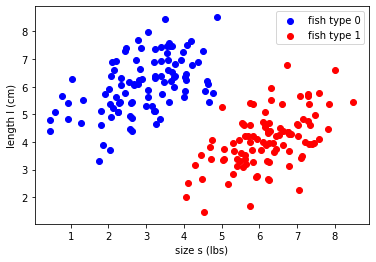

In [48]:
def scatter_data(x, label):
    """ a scatter plot of fish
    
    Args:
        x (np.array): (n_fish, 2) float, fish features for all fish, from
            both fish types.  Each row represents a fish's features.
        label (np.array): (n_fish) boolean.  describes which rows of x 
            correspond to which fish type.  (if label[idx_fish] = 0
            then the idx_fish row of x is of type 0)
    """
    plt.scatter(x[label==0, 0], x[label==0, 1], label='fish type 0', color='b')
    plt.scatter(x[label==1, 0], x[label==1, 1], label='fish type 1', color='r')
    plt.legend()
    plt.xlabel('size s (lbs)')
    plt.ylabel('length l (cm)')

    
    
x, label = get_fish_data(n_fish_per_grp=100)
scatter_data(x, label)

## How a trained perceptron would classify
A linear perceptron is just a line which tries to seperate the fish in the image above.  If a fish sits above this line, the linear perceptron classifies it as one type of fish.  Fish which sit below the line are classified as the other type of fish.  We can express the perceptron as a function $c$ which accepts a fish's features $x$ and returns an estimate of which fish type (either 0 or 1) $x$ is:

$$ c(x) = 
\left\{\begin{matrix}
1 \quad \text{if} \quad w \cdot x \geq 0
\\ 
0 \quad \text{if} \quad w \cdot x < 0
\end{matrix}\right.$$

It may not be clear that $w \cdot x$ defines a line, so lets unpack that a bit:

$$ w \cdot x = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} \cdot \begin{bmatrix} s \\ l \end{bmatrix} = w_0 s + w_1 l $$

If a fish's dot product is zero, it is the closest-call because even the smallest change might affter the perceptron's decision.  These fish, with $w \cdot x = 0$, define the decision boundary of the Perceptron:

$$ \vec{w} \cdot \vec{x} = 0 \implies l = -\frac{w_0}{w_1} s $$

which has a slope of -$\frac{w_0}{w_1}$ and an intercept of 0.  (More on the intercept of 0 later).  To test this out, lets see if we can come up with a $w$ which has a slope of 10.  $\vec{w} = \begin{bmatrix} -10 \\ 1 \end{bmatrix} $ should do it.  Lets plot:

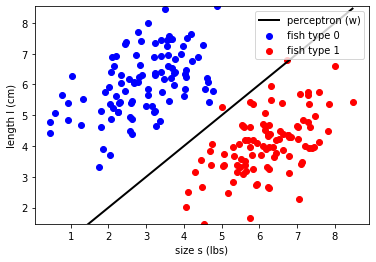

In [49]:
def plot_w(w, x):
    m = -w[0] / w[1]
    b = 0
    
    # a column vector of feature 1 for every sample
    feat_1 = x[:, 0]
    feat_2 = x[:, 1]
    
    x_boundary = np.linspace(feat_1.min(), feat_1.max(), 5)
    y_boundary =  m * x_boundary + b
    
    plt.plot(x_boundary, y_boundary, color='k', linewidth=2, label='perceptron (w)')
    plt.ylim(feat_2.min(), feat_2.max())
    plt.legend()
    
w = np.array([-1, 1])
scatter_data(x, label)
plot_w(w, x)

# Adding a bias term

Our decision line is currently $ l = - \frac{w_0}{w_1} s$, which is limited because it must pass through the origin.  That will be true of any perceptron that only takes the dot product of its weights and the inputs, because substituting the zero vector $\vec{0}$ for $\vec{v}$ will always be a solution to $\vec{w} \bullet \vec{v} = 0$. Ideally, we'd like to allow our model to have a decision boundary that doesn't need to pass through the origin.

To accomplish this, we'll use a common trick in Machine Learning: we'll add a feature that is always 1 to each fish feature vector.  So, a fish with a mass of 30 and length of 20 now has $x = \begin{bmatrix} 1 \\ 30 \\ 20 \end{bmatrix}$.  A fish with a mass of 100 and a length of 5 has $x = \begin{bmatrix} 1 \\ 100 \\ 5 \end{bmatrix}$.  It doesn't matter what fish we're talking about, their first feature is always 1.  If the weight for that fake feature (the "bias") is nonzero, this will cause the decision boundary to shift away from the origin.

Lets see how this changes our Linear Perceptron.  Now $\vec{w} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix}$ has 3 coefficients to accomodate our new, constant feature.  (The coefficient for the constant is sometimes called the bias.)  Again, our decision boundary are the set of all fish $\vec{x}$ whose dot product with $\vec{w}$ is 0:

$$ 0 =  \vec{x} \cdot \vec{w} =  \begin{bmatrix} 1 \\ s \\ l \end{bmatrix} \cdot \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix} = w_0 + w_1 s + w_2 l \implies l = - \frac{w_0}{w_2} - \frac{w_1}{w_2} s $$

This final line does what we're after.  Armed with this modified dataset, we can build a Linear Perceptron which may be any line, not just one which passes through the origin.  Let's modify our data to include this constant term:

In [50]:
# ensure all our numbers to 3 decimal places
np.set_printoptions(precision=2)

n_sample = x.shape[0]

# build a column vector of ones
constant_one_col = np.ones((n_sample, 1))
print(f'shape of constant_one_col: {constant_one_col.shape}')

# concatenate constant_one_col to x
print(f'first 5 fish in x:\n {x[:5, :]}')
x = np.concatenate((constant_one_col, x), axis=1)
print(f'first 5 fish in modified x:\n {x[:5, :]}')

shape of constant_one_col: (200, 1)
first 5 fish in x:
 [[1.27 4.67]
 [1.03 6.27]
 [1.87 3.89]
 [2.25 5.1 ]
 [2.88 6.29]]
first 5 fish in modified x:
 [[1.   1.27 4.67]
 [1.   1.03 6.27]
 [1.   1.87 3.89]
 [1.   2.25 5.1 ]
 [1.   2.88 6.29]]


Before continuing, lets update our `plot_w()` and `scatter_data()` functions.  They currently expect `x` and `w` to have 2 features but now they have 3 features.  We can also show how $w_0$ can slightly improve our model, by allowing the line to shift off the origin.

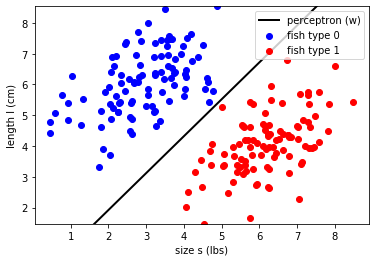

In [51]:
def plot_w(w, x):
    m = -w[1] / w[2]
    b = -w[0] / w[2]
    
    # a column vector of feature 1 for every sample
    feat_1 = x[:, 1]
    feat_2 = x[:, 2]
    
    x_boundary = np.linspace(feat_1.min(), feat_1.max(), 5)
    y_boundary =  m * x_boundary + b
    
    plt.plot(x_boundary, y_boundary, color='k', linewidth=2, label='perceptron (w)')
    plt.ylim(feat_2.min(), feat_2.max())
    plt.legend()
    
def scatter_data(x, label):
    """ a scatter plot of fish
    
    Args:
        x (np.array): (n_fish, 2) float, fish features for all fish, from
            both fish types.  Each row represents a fish's features.
        label (np.array): (n_fish) boolean.  describes which rows of x 
            correspond to which fish type.  (if label[idx_fish] = 0
            then the idx_fish row of x is of type 0)
    """
    plt.scatter(x[label==0, 1], x[label==0, 2], label='fish type 0', color='b')
    plt.scatter(x[label==1, 1], x[label==1, 2], label='fish type 1', color='r')
    plt.legend()
    plt.xlabel('size s (lbs)')
    plt.ylabel('length l (cm)')


# update our w vector to be 3 dimensional; add bias term
w = np.array([12, -30, 25])

# a quick plot to check that our updated functions work
scatter_data(x, label)
plot_w(w, x)

## How do we train a perceptron?

So far, we've seen how that a vector $w$ defines a perceptron which classifies fish as type 0 or type 1.  But none of this would be very exciting if we had to fiddle with the weights ourselves to build a classifier.  Instead, there's an algorithm for adjusting the weights automatically.

Heres the approach:

    1.  Pick any old weight vector w to start
    2.  For each fish f:
        2a.  classify f with the current weight vector w
        2b.  if the classification of f was incorrect, then update w to reduce this error
    3.  Repeat step 2 until we're satisfied that we should stop*
    
    *This issue is addressed in HW.
    
Lets say we have some type 1 fish $x$ for which $w \cdot x < 0$.  This will cause an error, as our perceptron will estimate it as type 0 (see definition of $c(x)$ above).  To reduce the error, lets update `w' = w + x` where `w'` is our new and improved `w`.  To see why this is a good idea, consider what the dot product looks like with our updated $w$:

$$ w' \cdot x = (w + x) \cdot x = \begin{bmatrix} w_0 + s \\ w_1 + l \end{bmatrix}  \cdot \begin{bmatrix} s \\ l \end{bmatrix} = (w_0 + s) s + (w_1 + l) l  = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}  \cdot \begin{bmatrix} s \\ l \end{bmatrix} + \begin{bmatrix} s \\ l \end{bmatrix} \cdot \begin{bmatrix} s \\ l \end{bmatrix} = \vec{w} \bullet \vec{x} + \vec{x} \bullet \vec{x}$$

The problem with our old $w$ was that $w \cdot x$ was too small.  Setting `w' = w + x` will ensure that $w'\cdot x$ is larger because $\vec{x} \bullet \vec{x}$ is non-negative if $\vec{x}$ isn't the zero vector.  (Notice that this is guaranteed to be true if we have a bias term.)

The other type of error we'll run into are fish of type 0 which have $w \cdot x \geq 0$.  This will cause an error as our perceptron will estimate them as type 1 even though they're actually type 0.  The algebra above can be modified slightly to show that by setting `w' = w - x` we will lower the dot product so our updated weight vector does a bit better next time.

In python: 

In [52]:
def update_perceptron(x, label, w):
    """ updates perceptron by updating once for each sample

    Args:
         x (np.array): (n_sample, n_feature) features
         label (np.array): (n_sample), boolean class label
         w (np.array): (n_feature) initial perceptron weights
         
    Returns:
        w (np.array): n_features weight vector, defines Linear
            Perceptron
    """
    n_sample, n_feature = x.shape

    for idx_sample in range(n_sample):
        # _x are the features of a single fish
        _x = x[idx_sample, :]
        
        # _label is the label, 0 or 1, of _x
        _label = label[idx_sample]

        if np.dot(_x, w) < 0 and _label:
            # perceptron estimate: type 0, actual fish type: 1
            w = w + _x
        elif np.dot(_x, w) >= 0 and not _label:
            # perceptron estimate: type 1, actual fish type: 0
            w = w - _x

    return w

Let's watch it learn by looking through the dataset 20 times (each run through the dataset is called an epoch) and updating according to all the errors it finds.  Click the whitespace to the left of the images to expand the graphs so you can view a few at a time.  Click the whitespace again to hide them again.

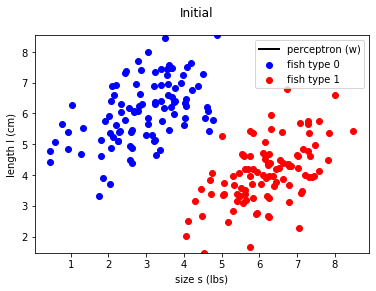

w = [1 2 3]
________________________________________________________________________________


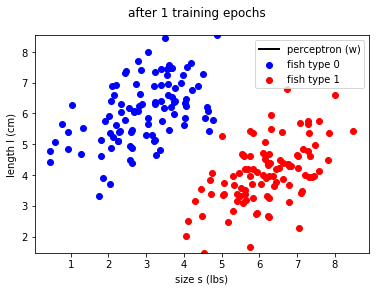

w = [1.   7.17 2.53]
________________________________________________________________________________


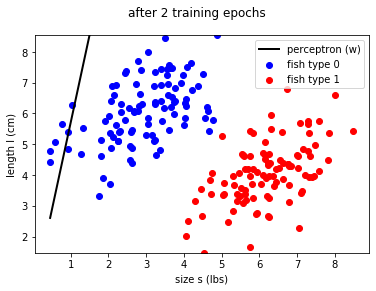

w = [ 0.   10.46 -1.84]
________________________________________________________________________________


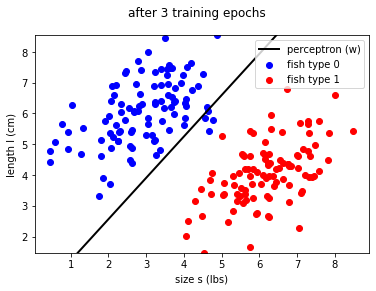

w = [-1.   10.87 -8.09]
________________________________________________________________________________


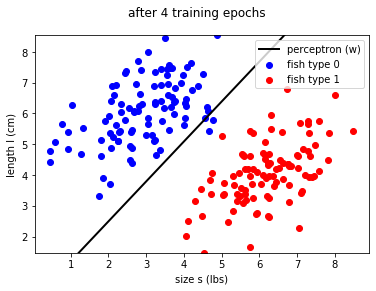

w = [-1.   12.55 -9.67]
________________________________________________________________________________


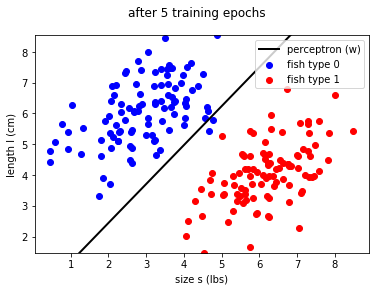

w = [ -1.    14.23 -11.25]
________________________________________________________________________________


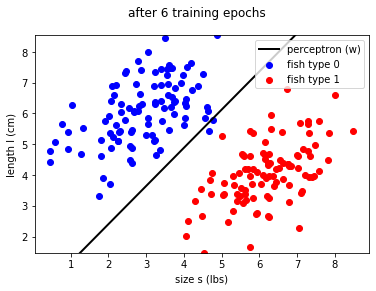

w = [ -1.    15.91 -12.82]
________________________________________________________________________________


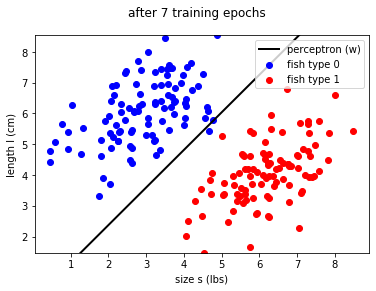

w = [ -1.    17.59 -14.4 ]
________________________________________________________________________________


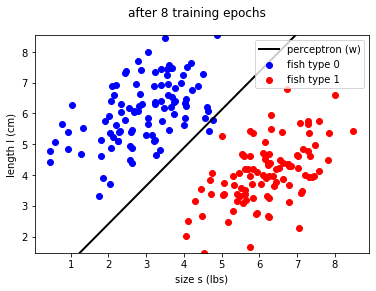

w = [ -1.    19.36 -15.65]
________________________________________________________________________________


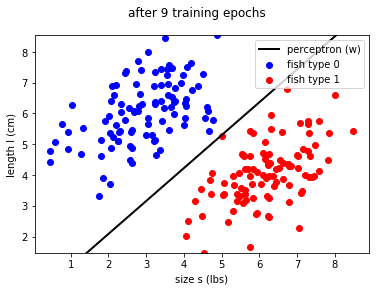

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


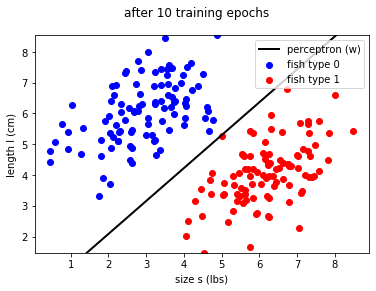

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


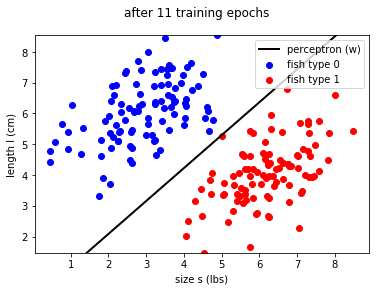

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


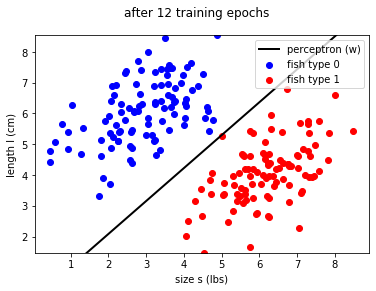

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


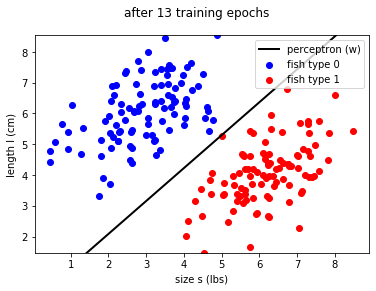

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


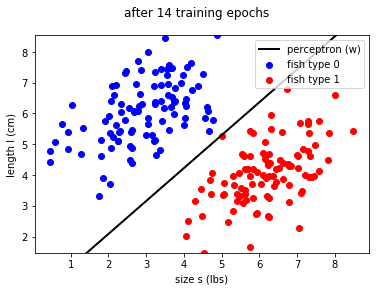

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


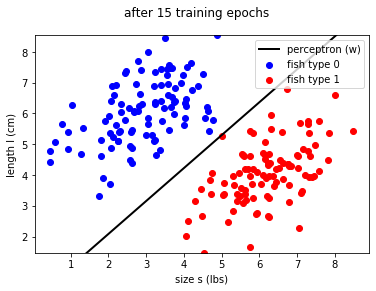

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


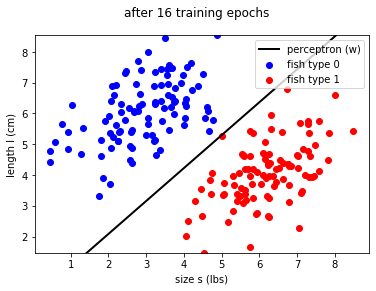

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


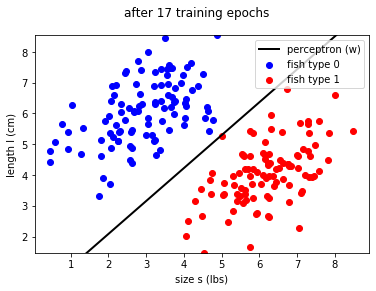

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


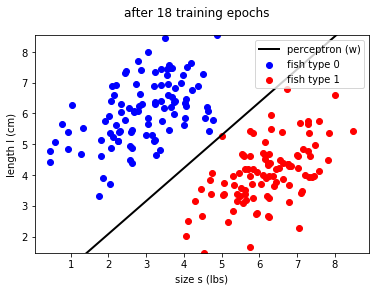

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


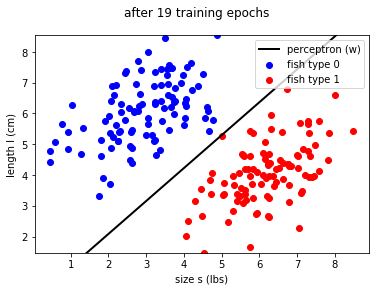

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


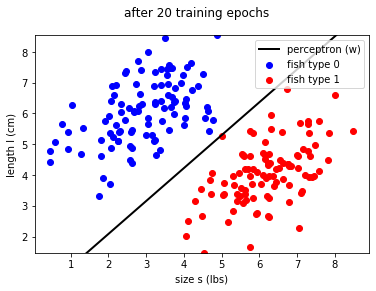

w = [ -1.    19.32 -18.05]
________________________________________________________________________________


In [53]:
# an arbitrary initialization (choose your own!)
w = np.array([1, 2, 3])

scatter_data(x, label)
plot_w(w, x)
plt.suptitle(f'Initial')
plt.show()
print(f'w = {w}')
print('_' * 80)

for idx_epoch in range(20):
    w = update_perceptron(x, label, w)
    
    scatter_data(x, label)
    plot_w(w, x)
    plt.suptitle(f'after {idx_epoch + 1} training epochs')
    plt.show()
    print(f'w = {w}')
    print('_' * 80)